# 气相反应

气相反应（gas-phase chemical reaction）来自 hilo-mpc 库的示例（https://hilo-mpc.github.io/hilo-mpc/examples/mhe_chemical_reaction.html）。

## 分析

这个方程并不算复杂，它表达了三种气体的反应速率关系，其中 $C_a$ 由 $C_b$ 和 $C_c$ 生成。

$$
\left\{
\begin{aligned}
C_a&=−(𝑘_1𝐶_𝑎−𝑘_{−1}𝐶_𝑏𝐶_𝑐)\\
C_b&=𝑘_1𝐶_𝑎−𝑘_{−1}𝐶_𝑏𝐶_𝑐−2(𝑘_2𝐶^2_𝑏−𝑘_{−2}𝐶_𝑐))\\
C_c&=𝑘_1𝐶_𝑎−𝑘_{−1}𝐶_𝑏𝐶_𝑐+(𝑘_2𝐶^2_𝑏−𝑘_{−2}𝐶_𝑐)\\
𝑦&=\frac{𝑅𝑇}V(𝐶_𝑎+𝐶_𝑏+𝐶_𝑐)
\end{aligned}
\right.
$$

因为项目中提供了训练数据，所以我们可以方便的验证我们的程序是否能正确的预测反应过程。

实际上 hilo mpc 的这个例子也是在底层拼装一个 CasADi 方程来计算。我这俩月的一个收获就是，
哎？这玩意儿好像也没那么复杂？

实际上这里只有一个时变微分方程，其它三个子项是描述三个反应物的速率和浓度之间的约束关系。

这个例子里对气相反应做了进一步简化，比如$RT/V$直接简化成了一个常数。这个子式代表的其实
是$\frac{气体常数*绝对温度}{体积}$ 。

## 实现

我们的实现目标和 hilo 的示例代码一样，预测三种气体的浓度随时间变化的过程。

In [1]:
# 环境准备

from casadi import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

我们直接使用示例中的初始参数。

In [2]:
# Known Parameters
k1_0 = 0.5
k_1_0 = 0.05
k2_0 = 0.2
k_2_0 = 0.01
RT_0 = 32.84  # L atm/ (mol) 

dt = 0.25


现在定义函数结构

In [3]:
# parameters
k1 = MX.sym('k1')
k_1 = MX.sym('k_1')
k2 = MX.sym('k2')
k_2 = MX.sym('k_2')
RT = MX.sym('RT')

p = vertcat(k1, k_1, k2, k_2, RT)

Ca = MX.sym('Ca')
Cb = MX.sym('Cb')
Cc = MX.sym('Cc')

dCa = -(k1*Ca - k_1*Cb*Cc)
dCb = k1*Ca - k_1*Cb*Cc - 2*(k2*Cb**2-k_2*Cc)
dCc = k1*Ca - k_1*Cb*Cc + (k2*Cb**2-k_2*Cc)
y = RT*(dCa + dCb + dCc)

state = vertcat(Ca, Cb, Cc)
statedot = vertcat(dCa, dCb, dCc) 

# 定义输出函数 y (例如用于残差计算)
y_expr = RT*(dCa + dCb + dCc)
# 构建积分器
# 创建积分器（单步）
F = integrator('F', 'cvodes', {'x': state, 'p': p, 'ode': statedot}, {'tf': dt})


CasADi - 2025-05-16 19:20:29 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:698]


这个实现有意思的地方在于，它的输入输出和参数都是向量。这比之前的简谐运动略复杂一点，但是对 CasADi 其实是很自然的。
CasADi 从设计上就是把矩阵做为基本类型，而标量只是 1x1 的特殊矩阵。后续代码中的的 x0 和 params 的定义直接将
符号定义为一维矩阵。

现在，执行函数，收集计算得到的预测数据，我们希望不依赖 hilo 得到其 MHE 计算结果。

In [4]:
# 构建多步预测器
x0 = MX.sym('x0', 3)     # 初始状态
params = MX.sym('p', 5)  # 参数
N = 120                   # 设置预测步长（你可以修改）

X = x0                   # 初始状态
X_all = [X]              # 储存所有状态

for i in range(N):
    res = F(x0=X, p=params)
    X = res['xf']
    X_all.append(X)

# 输出为 shape=(3, N+1)
X_all_stack = horzcat(*X_all)

# 构建函数
multi_step_predictor = Function('multi_step_predictor', [x0, params], [X_all_stack])

现在，我们把数据画出来观察一下。

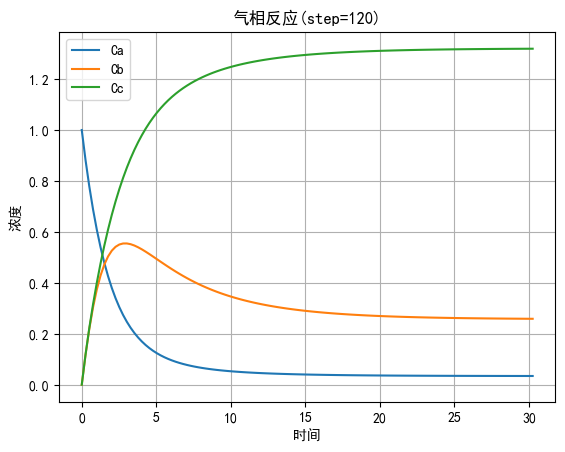

In [5]:
# 初始状态
x0_val = np.array([1.0, 0.0, 0.0])

# 参数（真实值或估计值）
p_val = np.array([0.5, 0.05, 0.2, 0.01, 32.84])

# 调用多步预测器
X_pred = multi_step_predictor(x0_val, p_val)

# 转换为 numpy 并绘图
X_pred = np.array(X_pred)

import matplotlib.pyplot as plt
t = np.linspace(0, dt * X_pred.shape[1], X_pred.shape[1])

plt.plot(t, X_pred[0, :], label='Ca')
plt.plot(t, X_pred[1, :], label='Cb')
plt.plot(t, X_pred[2, :], label='Cc')
plt.xlabel('时间')
plt.ylabel('浓度')
plt.legend()
plt.grid(True)
plt.title(f'气相反应(step={N})')
plt.show()


Hilo 项目的 demo 比较散乱，并且它的点图和曲线其实来自同一组数据，并没有起到对照的作用。读者可以比较一下我们和 hilo 
的数据曲线。